In [1]:
# Retirement calculator using Monte Carlo simulation.
# Load imports
import sys
import colorama 
from colorama import Fore
import random
import plotly.express as px
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# Open a data file in percent format and convert to decimal & return a list.
def read_list(file_name):
    with open(file_name) as file:
        line_var = [float(line.strip()) for line in file]
        decimal_var = [round(line / 100, 4) for line in line_var]
        return decimal_var

In [3]:
# Setup default values in input string
def def_input(prompt, default=None):
    prompt = '{} [{}]: '.format(prompt, default)
    response = input(prompt)
    if not response and default:
        return default
    else:
        return response

In [4]:
# These txt files are solely for testing purposes we will need to read
# from a CSV file using pd for the final product
# load data files with original data in percent form
try:
    bonds = read_list('./Resources/10yr_TBond_1928-2021_pct.txt')
    stocks = read_list('./Resources/SP500_returns_1928-2021_pct.txt')
    blend_40_50_10 = read_list('./Resources/SBC_blend_1928-2021_pct.txt')
    blend_50_50 = read_list('./Resources/SB_blend_1928-2021_pct.txt')
    ratio_60_40 = read_list('./Resources/60_40_ratio_1928-2021.txt')
    infl_rate = read_list('./Resources/annual_infl_rate_1928-2021_pct.txt')
except IOError as e:
    print("{}. \nTerminating program.".format(e), file=sys.stderr)
    sys.exit(1)

In [5]:
# get user input with dictionary for investment types
investment_type = {'bonds': bonds, 'stocks': stocks, '60/40': ratio_60_40,
                        'sb': blend_50_50, 'sbc': blend_40_50_10}

In [6]:
# print header logo
print("\n \n")
print(Fore.RED +"   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(Fore.WHITE +"  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(Fore.BLUE +" ~~   $                                                         $   ~~")
print(Fore.BLUE +"~~   $ $       R E T I R E M E N T     S I M U L A T O R       $ $   ~~")
print(Fore.BLUE +" ~~   $                                                         $   ~~")
print(Fore.WHITE +"  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(Fore.RED +"   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

# print user questions
print(Fore.WHITE +"   How long will your retirement nest egg last?\n   How much could your investments grow?\n   Answer a few questions to see a long-term projection.\n   Then try making a few changes to view the impact on your results.\n\n")

# print input legend for user
print("      How are your savings allocated?\n")
print("      Stocks = S&P 500")
print("      Bonds = 10 year Treasury Bond")
print("      60/40 = 60% S&P 500 / 40% Treasury Bond")
print("      SB Blend = 50% S&P 500 / 50% Treasury Bond")
print("      SBC Blend = 40% S&P 500 / 50% Treasury Bond / 10% Cash")
print(Fore.GREEN +"      Crypto =  F U T U R E   F U N C T I O N A L I T Y")
print(Fore.GREEN +"      Custom =  F U T U R E   F U N C T I O N A L I T Y\n")
print(Fore.WHITE +"      Press ENTER to accept default value shown in [brackets]. \n")



 

   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 ~~   $                                                         $   ~~
~~   $ $       R E T I R E M E N T     S I M U L A T O R       $ $   ~~
 ~~   $                                                         $   ~~
  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

   How long will your retirement nest egg last?
   How much could your investments grow?
   Answer a few questions to see a long-term projection.
   Then try making a few changes to view the impact on your results.


      How are your savings allocated?

      Stocks = S&P 500
      Bonds = 10 year Treasury Bond
      60/40 = 60% S&P 500 / 40% Treasury Bond
      SB Blend = 50% S&P 500 / 50% Treasury Bond
      SBC Blend = 40% S&P 500 / 50% Treasury Bond / 10% Cash
      Crypto =  F U T U R E   F 

In [7]:
# get user input
invest_type = def_input("Enter investment type: (stocks, bonds, 60/40, sb,"\
                     " sbc): \n", '60/40').lower()

while invest_type not in investment_type:
    invest_type = input("Invalid investment. Enter investment type " \
                    "as listed in prompt: ")

start_value = def_input("Input starting value of investments: \n", \
                             '1000000')
while not start_value.isdigit():
    start_value = input("Invalid input! Input whole numbers only: ")

withdrawal = def_input("How much do you spend each year?" \
                            " (in today's $): \n", '60000')
while not withdrawal.isdigit():
    withdrawal = input("Invalid input! Input whole numbers only: ")

min_years = def_input("Input minimum years in retirement: \n", '18')
while not min_years.isdigit():
    min_years = input("Invalid input! Input whole numbers only: ")

most_likely_years = def_input("Input most-likely years in retirement: \n",
                                  '25')
while not most_likely_years.isdigit():
    most_likely_years = input("Invalid input! Input whole numbers only: ")

max_years = def_input("Input maximum years in retirement: \n", '40')
while not max_years.isdigit():
    max_years = input("Invalid input! Input whole numbers only: ")
    
num_cases = def_input("Input number of Monte Carlo Simulations (MCS) to run: \n", '50000')
while not num_cases.isdigit():
    num_cases = input("Invalid input! Input whole numbers only: ")

# check for input errors
if not int(min_years) < int(most_likely_years) < int(max_years) \
   or int(max_years) > 100:
    print("\nATTENTION: The input years that you entered are not valid.", file=sys.stderr)
    print("\nTIP: Min years need to be less than Most Likey years and less than your Max years.\nAlso, Max years cannot exceed 100. Please Try again!\n \n", file=sys.stderr)
    sys.exit(1)

Enter investment type: (stocks, bonds, 60/40, sb, sbc): 
 [60/40]:  
Input starting value of investments: 
 [1000000]:  
How much do you spend each year? (in today's $): 
 [60000]:  
Input minimum years in retirement: 
 [18]:  
Input most-likely years in retirement: 
 [25]:  
Input maximum years in retirement: 
 [40]:  
Input number of Monte Carlo Simulations (MCS) to run: 
 [50000]:  


In [8]:
# Run MCS and return investment value at end-of-plan and bankrupt count.
def montecarlo(returns):
    case_count = 0
    bankrupt_count = 0
    outcome = []

    while case_count < int(num_cases):
        investments = int(start_value)
        start_year = random.randrange(0, len(returns))        
        duration = int(random.triangular(int(min_years), int(max_years),
                                         int(most_likely_years)))       
        end_year = start_year + duration 
        lifespan = [i for i in range(start_year, end_year)]
        bankrupt = 'no'

        # build temporary lists for each case
        lifespan_returns = []
        lifespan_infl = []
        for i in lifespan:
            lifespan_returns.append(returns[i % len(returns)])
            lifespan_infl.append(infl_rate[i % len(infl_rate)])
            
        # loop through each year of retirement for each sim run
        for index, i in enumerate(lifespan_returns):
            infl = lifespan_infl[index]

            # do not adjust for inflation the first year
            if index == 0:
                withdraw_infl_adj = int(withdrawal)
            else:
                withdraw_infl_adj = int(withdraw_infl_adj * (1+infl))

            investments -= withdraw_infl_adj
            investments = int(investments * (1 + i))

            if investments <= 0:
                bankrupt = 'yes'
                break

        if bankrupt == 'yes':
            outcome.append(0)
            bankrupt_count += 1
        else:
            outcome.append(investments)
            
        case_count += 1

    return outcome, bankrupt_count


In [9]:
# Calculate and determine the chance of running out of money along with other stats.
def bankrupt_prob(outcome, bankrupt_count):
    total = len(outcome)
    odds = round(100 * bankrupt_count / total, 1)

    print("\nInvestment type: {}".format(invest_type))
    print("Starting value: ${:,}".format(int(start_value)))
    print("Annual withdrawal: ${:,}".format(int(withdrawal)))
    print("Years in retirement (min - most likey - max): {}-{}-{}"
          .format(min_years, most_likely_years, max_years))
    print("Number of MCS runs: {:,}\n".format(len(outcome)))
    print(Fore.RED + "Likelihood of you outliving your money: {}%\n".format(odds))
    print(Fore.WHITE + "Average outcome: ${:,}".format(int(sum(outcome) / total)))
    print("Minimum outcome: ${:,}".format(min(i for i in outcome)))
    print("Maximum outcome: ${:,}".format(max(i for i in outcome)))
    print(Fore.CYAN +"\nThis retirement simulation was provided to you by:\nHunter, Thomas, Jeff and Ray, aka 'The PHX Mafia'\n\n")
    return odds


Investment type: 60/40
Starting value: $1,000,000
Annual withdrawal: $60,000
Years in retirement (min - most likey - max): 18-25-40
Number of MCS runs: 50,000

Odds of running out of money: 34.5%

Average outcome: $1,469,500
Minimum outcome: $0
Maximum outcome: $19,406,008

This retirement simulation was provided to you by:
Hunter, Thomas, Jeff and Ray, aka 'The PHX Mafia'




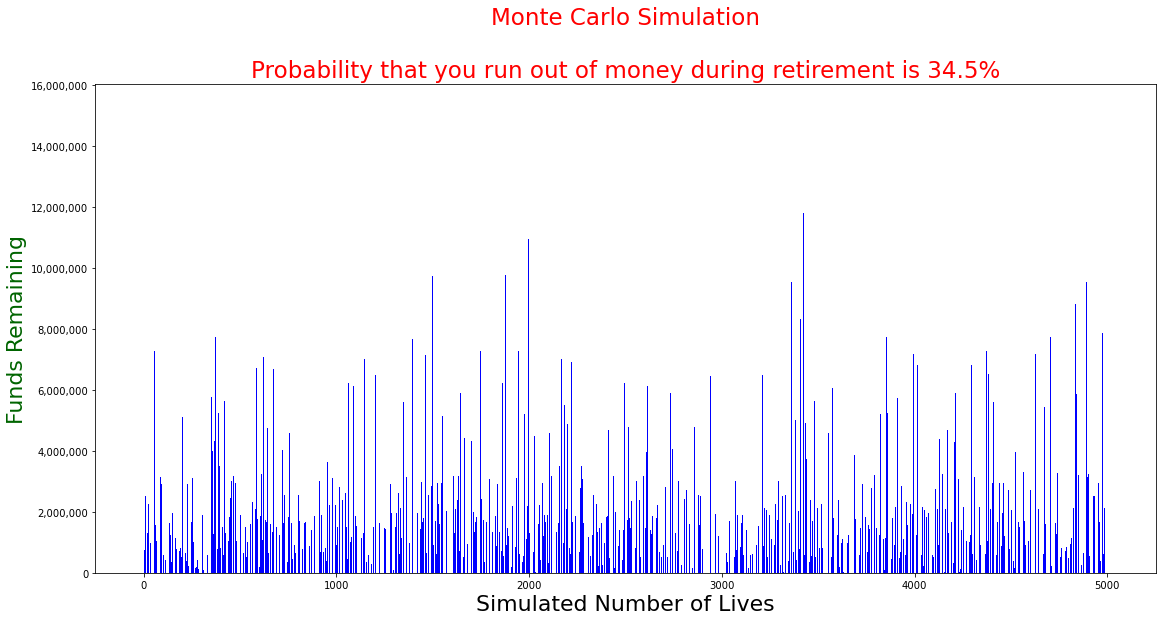

In [10]:
# Call MCS & bankrupt functions and plot bar chart of MCS sim results. Generate matplotlib bar chart plot first 5000 runs 
def main():    
    outcome, bankrupt_count = montecarlo(investment_type[invest_type])
    odds = bankrupt_prob(outcome, bankrupt_count)  
    plotdata = outcome[:5000]
    plt.figure('This retirement simulation was provided to you by, Hunter, Thomas, Jeff and Ray (showing first {} MCS runs)'.format(len(plotdata)),figsize=(19, 9))
    index = [i + 1 for i in range(len(plotdata))]
    plt.bar(index, plotdata, color='blue')
    plt.xlabel('Simulated Number of Lives', fontsize=22)
    plt.ylabel('Funds Remaining',color='darkgreen', fontsize=22)
    plt.ticklabel_format(style='scientific', axis='y')
    ax = plt.gca()
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}"
                                                         .format(int(x))))
    plt.title('Monte Carlo Simulation\n\nProbability that you run out of money during retirement is {}%'.format(odds),fontsize=23, color='red')
    plt.show()

# run the simulation program
if __name__ == '__main__':
    main()